## **Delay Feature Analysis**

In this notebook, we explore the dataset’s key columns containing detailed flight information and conduct preliminary analysis to identify which features influence flight delays and to what extent. 

The goal is to uncover meaningful patterns, trends, and correlations that can inform feature selection for use in delay prediction models.

#### **Loading Cleaned Dataset**

We begin by loading the cleaned dataset.

In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("cleaned_flight_data.csv", encoding="ISO-8859-1", low_memory=False)
df

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum
0,1998,1,1,2,5,1998-01-02,NW,19386,NW,N297US,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,2,5,28,4,2009-05-28,FL,20437,FL,N946AT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,2,6,29,6,2013-06-29,MQ,20398,MQ,N665MQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,3,8,31,2,2010-08-31,DL,19790,DL,N6705Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006,1,1,15,7,2006-01-15,US,20355,US,N504AU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,2008,1,3,23,7,2008-03-23,WN,19393,WN,N712SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999996,1999,1,1,5,2,1999-01-05,CO,19704,CO,N14308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999997,2003,4,11,14,5,2003-11-14,US,20355,US,N528AU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999998,2012,2,5,15,2,2012-05-15,WN,19393,WN,N281WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# How is Delay defined in the dataset?

A flight is considered delayed if its recorded arrival delay (ArrDelay) exceeds zero minutes. For the purpose of classification modeling, we will convert this into a binary target variable, DelayCategory, where delayed flights are labeled as 1 and on-time or early flights as 0. This approach simplifies the analysis and makes it suitable for binary classification.

**Key Columns**:

- CRSArrTime: Scheduled times for arrival.

- ArrTime: Actual times for arrival.

- ArrDelay: Represent the difference between the scheduled and actual times. Negative values indicate early departures/arrivals, while positive values indicate delays. Flights with no delays have values of 0 in these columns.

**Delay Formula**:

ArrDelay = CRSArrTime - ArrTime

This definition provides a clear framework for analyzing flight delays and predicting them as a binary classification problem.

---------------------------------------------------------------------------------------------------------------------

#### **Preprocessing and Feature Engineering for Flight Delay Prediction**

This code prepares a flight dataset for delay prediction by selecting relevant features, creating a binary delay label, and engineering new features to better represent temporal patterns and flight routes. 

It includes steps like categorizing departure times, calculating total delays from various causes, identifying weekend flights, and removing raw delay columns no longer needed for modeling.

By displaying the dataset with all features and the Delay label, so we can visually explore which factors might be linked to delayed flights.

In [2]:
# ---- Step 1: Basic Feature Selection ----
# Pick only useful columns and make a copy to avoid SettingWithCopyWarning
df_selected = df[[
    'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline',
    'Origin', 'Dest', 'CRSDepTime', 'CRSArrTime',
    'Distance', 'DepDelay', 'ArrDelay', 
    'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'SecurityDelay',
    'Cancelled', 'Diverted'
]].copy()

# ---- Step 2: Create a Delay Label ----
# Target: 1 if arrival delay > 0 minutes, else 0
df_selected.loc[:, 'Delay'] = (df_selected['ArrDelay'] > 0).astype(int)

# ---- Step 3: Feature Engineering ----

# Create Part of Day
def part_of_day(dep_time):
    if pd.isnull(dep_time):
        return 'Unknown'
    dep_time = int(dep_time)
    if dep_time < 600:
        return 'Early Morning'
    elif dep_time < 1200:
        return 'Morning'
    elif dep_time < 1700:
        return 'Afternoon'
    elif dep_time < 2100:
        return 'Evening'
    else:
        return 'Night'

df_selected.loc[:, 'PartOfDay'] = df_selected['CRSDepTime'].apply(part_of_day)

# Create Total Delay
df_selected.loc[:, 'TotalDelay'] = df_selected[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']].sum(axis=1)

# Create Route
df_selected.loc[:, 'Route'] = df_selected['Origin'] + '_' + df_selected['Dest']

# Weekend flag
df_selected.loc[:, 'IsWeekend'] = df_selected['DayOfWeek'].apply(lambda x: 1 if x in [6,7] else 0)

# ---- Step 4: Drop columns you no longer need ----
df_model = df_selected.drop(['DepDelay', 'ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay'], axis=1)

# ---- Step 5: Check result ----

# Adjust pandas options to display more rows and columns
pd.set_option('display.max_rows', 20)  # Show up to 20 rows (can adjust this number)
pd.set_option('display.max_columns', None)  # Show all columns

# Print the DataFrame to display in a nice table-like format
print(df_model)

         Month  DayofMonth  DayOfWeek Reporting_Airline Origin Dest  \
0            1           2          5                NW    MSP  SLC   
1            5          28          4                FL    MKE  MCO   
2            6          29          6                MQ    GJT  DFW   
3            8          31          2                DL    LAX  DTW   
4            1          15          7                US    EWR  CLT   
...        ...         ...        ...               ...    ...  ...   
1999995      3          23          7                WN    LAS  PHX   
1999996      1           5          2                CO    EWR  DFW   
1999997     11          14          5                US    CHS  CLT   
1999998      5          15          2                WN    MDW  BNA   
1999999      4          29          2                UA    IAD  ORD   

         CRSDepTime  CRSArrTime  Distance  SecurityDelay  Cancelled  Diverted  \
0              1000        1116     991.0            0.0        0.

#### **Initial Insights**

We now have a structured dataset with 17 features and 2 million rows, each representing a flight. 

The Delay column acts as our target, indicating whether a flight arrived late. 

Most entries show TotalDelay as 0.0, meaning the majority of flights in this sample did not experience recorded delays due to known causes like weather or aircraft issues. 

Most flights occurred during the Morning and on weekdays (IsWeekend = 0), suggesting typical travel patterns. 

A quick glance also reveals diversity in routes and airlines, which provides rich ground for exploring which specific conditions—like departure time, distance, or day of week—might correlate with delays.

---------------------------------------------------------------------------------------------------------------------

## **Analysis of Flight Delays by Different Delay Types**

This section analyzes how various delay types—NAS, Weather, Carrier, Late Aircraft, and Security—impact the likelihood of a flight experiencing an arrival delay. 

By creating binary columns for each delay type and using crosstabs, we can better understand the relationship between these factors and overall flight delays.

---------------------------------------------------------------------------------------------------------------------

#### **Exploring the Impact of NAS Delays and Arrival Delays**

This step creates a binary label (Delay) to indicate whether a flight was delayed upon arrival. It also introduces a new feature, HasNASDelay, to flag whether a National Airspace System (NAS) delay occurred. 

A crosstab is then generated to observe how the presence of NAS delays correlates with actual arrival delays, normalized by row to highlight proportional differences.

In [ ]:
# Target: 1 if arrival delay > 0 minutes, else 0
df_selected.loc[:, 'Delay'] = (df_selected['ArrDelay'] > 0).astype(int)

# Create a new column 
df_selected['HasNASDelay'] = (df_selected['NASDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasNASDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasNASDelay,,
0,0.608827,0.391173
1,0.000000,1.000000


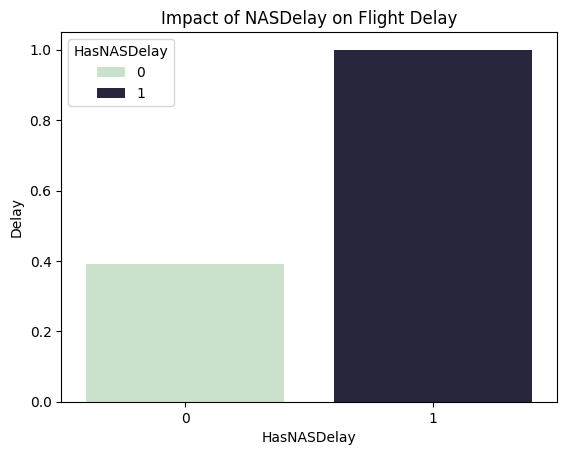

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasNASDelay', y='Delay', data=df_selected, palette = 'ch:s=-.4,r=.9', hue='HasNASDelay')
plt.title('Impact of NASDelay on Flight Delay')
plt.show()

The crosstab reveals a strong association between NAS delays and arrival delays. 

Specifically, 100% of flights with a NAS delay (HasNASDelay = 1) resulted in an arrival delay (Delay = 1), confirming that NAS issues are a direct cause of late arrivals. 

In contrast, among flights without a NAS delay, only about 39% were delayed, suggesting that other factors may contribute to delays, but the presence of a NAS delay almost guarantees a late arrival.

---------------------------------------------------------------------------------------------------------------------

#### **Exploring the Impact of Weather Delays on Arrival Delays**

This step adds a new binary column, HasWeatherDelay, to indicate whether a flight experienced any delay due to weather. 

The crosstab then compares this feature with the Delay label to understand how strongly weather-related issues influence the likelihood of arriving late.

In [ ]:
# Create a new column 
df_selected['HasWeatherDelay'] = (df_selected['WeatherDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasWeatherDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasWeatherDelay,,
0,0.574213,0.425787
1,0.000000,1.000000


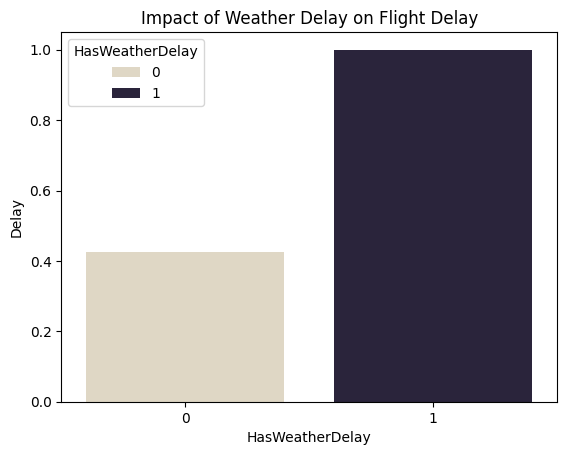

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasWeatherDelay', y='Delay', data=df_selected, palette='ch:s=-.2,r=.6', hue='HasWeatherDelay')
plt.title('Impact of Weather Delay on Flight Delay')
plt.show()

The results show that all flights with a recorded weather delay (HasWeatherDelay = 1) experienced an arrival delay, confirming a direct and strong link between weather issues and late arrivals. 

Among flights without weather delays, around 42.6% were still delayed, suggesting that while weather is a highly reliable predictor of delays when present, a substantial portion of delays still occur due to other factors. 

---------------------------------------------------------------------------------------------------------------------

#### **Exploring the Impact of Carrier Delays on Arrival Delays**

This step introduces the binary feature HasCarrierDelay, indicating whether a flight experienced a delay caused by the airline carrier. 

A normalized crosstab is then used to analyze how the presence of a carrier delay correlates with the likelihood of an arrival delay.

In [ ]:
# Create a new column 
df_selected['HasCarrierDelay'] = (df_selected['CarrierDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasCarrierDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasCarrierDelay,,
0,0.601695,0.398305
1,0.000000,1.000000


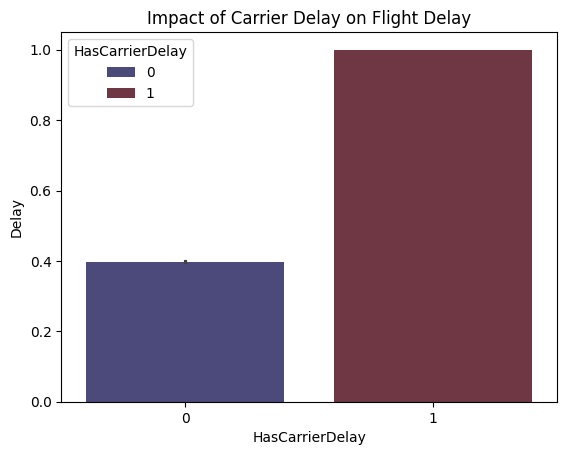

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasCarrierDelay', y='Delay', data=df_selected, palette='icefire', hue='HasCarrierDelay')
plt.title('Impact of Carrier Delay on Flight Delay')
plt.show()

The crosstab indicates that 100% of flights with a carrier delay (HasCarrierDelay = 1) were also delayed upon arrival, demonstrating a perfect association between carrier-related issues and late arrivals. 

For flights without carrier delays, approximately 39.8% still experienced delays, implying that while carrier delays are a strong and direct cause when present, other factors also contribute significantly to overall delay rates.

#### **Exploring the Impact of Late Aircraft Delays on Arrival Delays**

This step introduces the binary feature HasLateAircraftDelay to indicate whether a flight experienced a delay due to late aircraft. 

A normalized crosstab is then used to analyze how these late aircraft delays are associated with arrival delays.

In [ ]:
# Create a new column 
df_selected['HasLateAircraftDelay'] = (df_selected['LateAircraftDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasLateAircraftDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasLateAircraftDelay,,
0,0.60293,0.39707
1,0.00000,1.00000


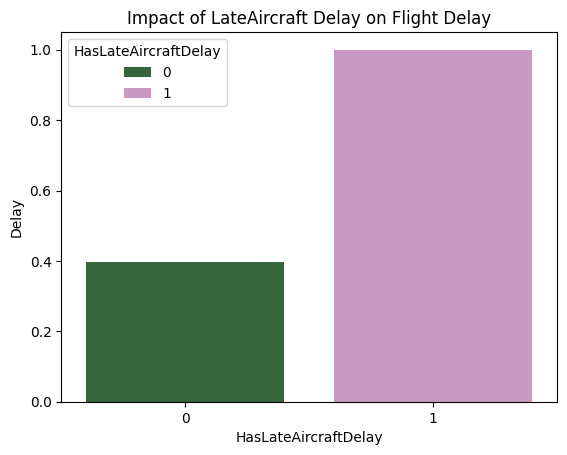

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasLateAircraftDelay', y='Delay', data=df_selected, palette='cubehelix', hue='HasLateAircraftDelay')
plt.title('Impact of LateAircraft Delay on Flight Delay')
plt.show()

The crosstab reveals that 100% of flights with a late aircraft delay (HasLateAircraftDelay = 1) also experienced an arrival delay, indicating a perfect correlation between this type of delay and late arrivals. 

For flights without a late aircraft delay, about 39.7% were still delayed, suggesting that while late aircraft delays are a decisive factor in causing late arrivals, other delay types still account for a significant portion of overall delays.

---------------------------------------------------------------------------------------------------------------------

#### **Exploring the Impact of Security Delays on Arrival Delays**

This step selects relevant columns for analysis and creates the binary feature HasSecurityDelay to indicate whether a flight experienced a delay due to security. 

A normalized crosstab is then used to assess the relationship between security delays and arrival delays.

In [ ]:
# Select the needed columns and make a copy to avoid SettingWithCopyWarning
df_selected = df_selected[['SecurityDelay', 'Delay']].copy()

# Create a new column 
df_selected['HasSecurityDelay'] = (df_selected['SecurityDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasSecurityDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasSecurityDelay,,
0,0.570487,0.429513
1,0.000000,1.000000


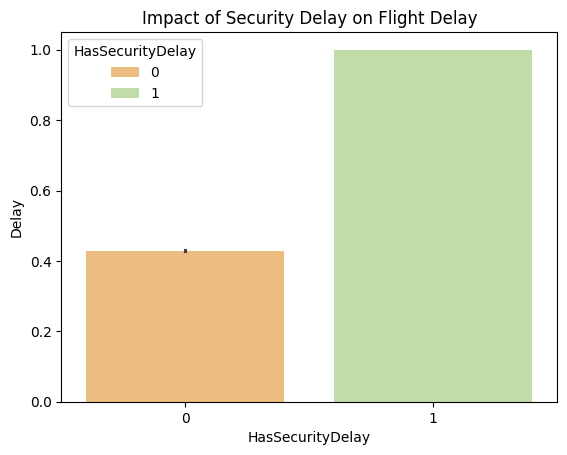

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasSecurityDelay', y='Delay', data=df_selected, palette='Spectral', hue='HasSecurityDelay')
plt.title('Impact of Security Delay on Flight Delay')
plt.show()

The crosstab results show that 100% of flights with a security delay (HasSecurityDelay = 1) experienced an arrival delay, indicating a direct and complete link between security-related delays and late arrivals. 

For flights without a security delay, about 42.9% were still delayed, suggesting that while security issues are a decisive factor for delays when present, other causes contribute to delays as well.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

---------------------------------------------------------------------------------------------------------------------

## **Number of Arrival Delayed Flights by Month**

X-Axis: Month
This axis represents the months of the year, labeled from January (Jan) to December (Dec).

Y-Axis: Number of Arrival Delays
This axis shows the count of flights that experienced an arrival delay in each respective month.

This axis shows the count of flights that experienced an arrival delay in each respective month. The plot will highlights how delays fluctuate throughout the year, seeing which months experience a higher numbers of delayed flights.

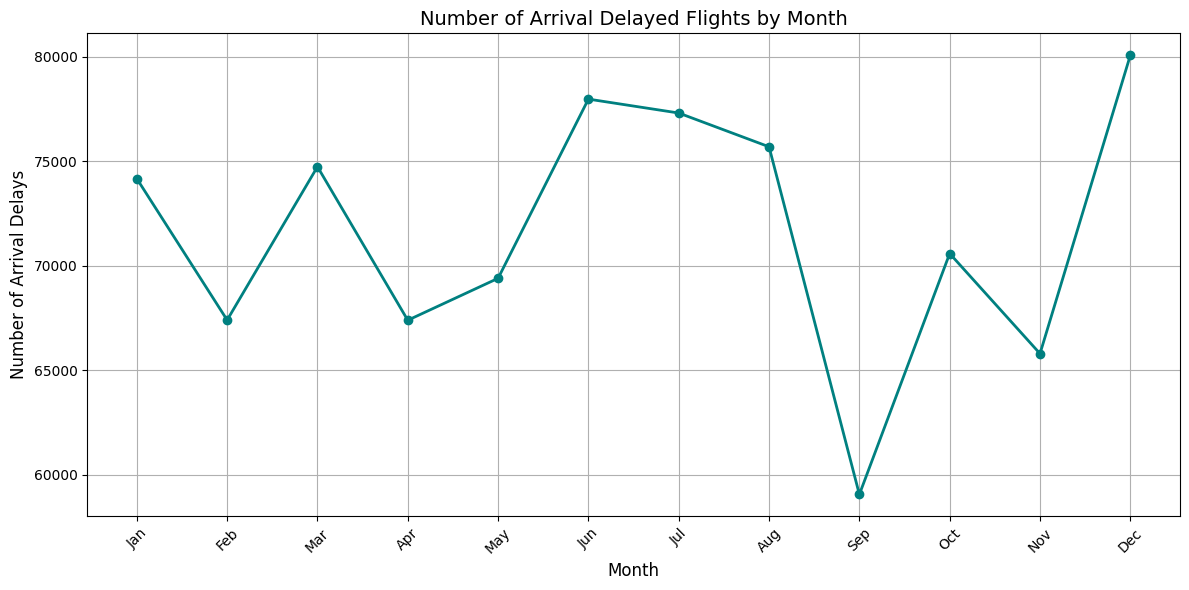

In [11]:
import matplotlib.pyplot as plt

# Drop rows with NaN values in 'ArrDelay' and 'Month'
df = df.dropna(subset=['ArrDelay', 'Month'])

# Filter rows where arrival delay is greater than 0
delayed_flights = df[df['ArrDelay'] > 0]

# Calculate number of arrival-delayed flights by month
monthly_delayed_flights = delayed_flights.groupby('Month').size()

# Plot the number of arrival-delayed flights by month using a line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_delayed_flights.index, monthly_delayed_flights.values, marker='o', color='teal', linewidth=2)

# Add titles and labels
plt.title('Number of Arrival Delayed Flights by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Arrival Delays', fontsize=12)

# Customize x-ticks with month names
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Show grid
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

The plot reveals that January, March, June, July, August, and December experience a higher count of arrival delays compared to other months. 

This is likely influenced by a combination of factors such as weather conditions, peak travel seasons, and holidays. 

For instance, January and December could see more weather-related delays due to winter storms, while March, June, July, and August are popular travel months with higher traffic, leading to congestion and delays. 

The holiday season in December also contributes to increased delays, as airports experience more passengers and potential disruptions. 

Thus, the month of the flight can impact delays, with certain months experiencing more disruptions due to weather patterns, increased travel volume, and peak holiday seasons.

---------------------------------------------------------------------------------------------------------------------

## **Number of Arrival Delays by Arrival Hour**

X-axis: Arrival Hour (0 to 23)

Y-axis: Number of Arrival Delays

The plot shows how the number of arrival delays varies across different hours of the day. The x-axis represents the arrival hours (from 0 to 23), while the y-axis indicates the number of delayed flights during each hour. This visualization helps to identify peak hours during which arrival delays are most frequent.

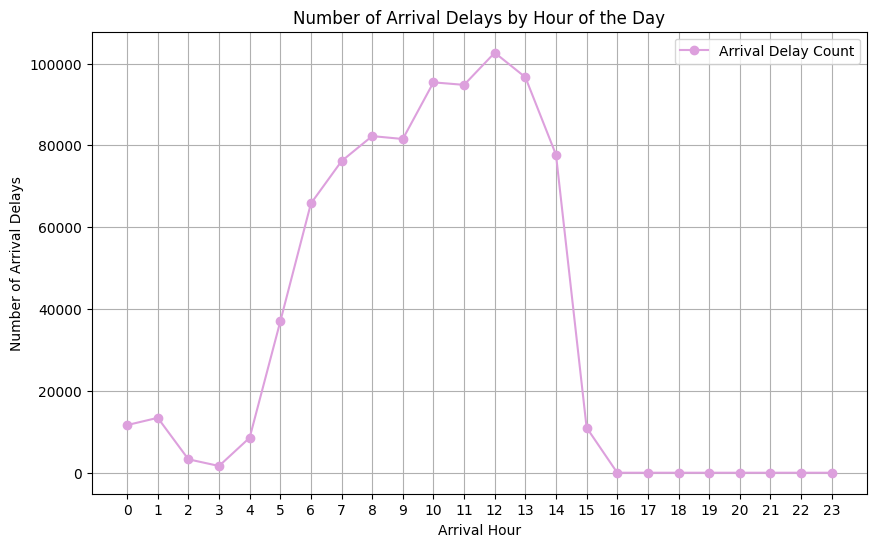

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert ArrTime to hours, handle 24-hour clock properly
df['ArrHour'] = (df['ArrTime'] // 100) + (df['ArrTime'] % 100) / 60.0
df['ArrHour'] = df['ArrHour'].round()  # Round hours for grouping

# Filter the dataset to include only rows with arrival delays
df_delayed = df[df['ArrDelay'] > 0].copy()

# Count the number of arrival delays by arrival hour (ensure full range 0-23)
delay_count_by_hour = df_delayed.groupby('ArrHour').size().reindex(range(24), fill_value=0)

# Plotting the Arrival Delay Counts by Hour of the Day
plt.figure(figsize=(10, 6))
plt.plot(delay_count_by_hour.index, delay_count_by_hour.values, marker='o', color='plum', label='Arrival Delay Count')
plt.title('Number of Arrival Delays by Hour of the Day')
plt.xlabel('Arrival Hour')
plt.ylabel('Number of Arrival Delays')
plt.grid(True)
plt.legend()
plt.xticks(range(24))  # Show all hours from 0 to 23
plt.show()


The plot illustrates how the number of arrival delays varies across the arrival hours of the day, with a notable peak between 7 AM and 2 PM, where delays are most frequent. 

This could indicate that delays are more likely to accumulate during peak travel hours, potentially due to heavier air traffic or operational bottlenecks. 

Insights like this suggest that earlier hours, especially the morning, may be more vulnerable to disruptions, possibly due to overnight scheduling issues or the cumulative effect of delays from previous flights. 

Recognizing these trends can help identify key times for improvement in airport operations, staffing, or flight scheduling to minimize delays.

---------------------------------------------------------------------------------------------------------------------

## **Number of Arrival Delays by Scheduled Arrival Hour**

X-axis: Scheduled Arrival Hour (0–23)

Y-axis: Number of Arrival Delays

This plot demonstrates the number of delays for flights across different scheduled arrival times. The x-axis shows the scheduled arrival hours (from 0 to 23), and the y-axis represents the count of flights that experienced delays for each of these scheduled times. It helps identify at which scheduled arrival hours delays are more common.

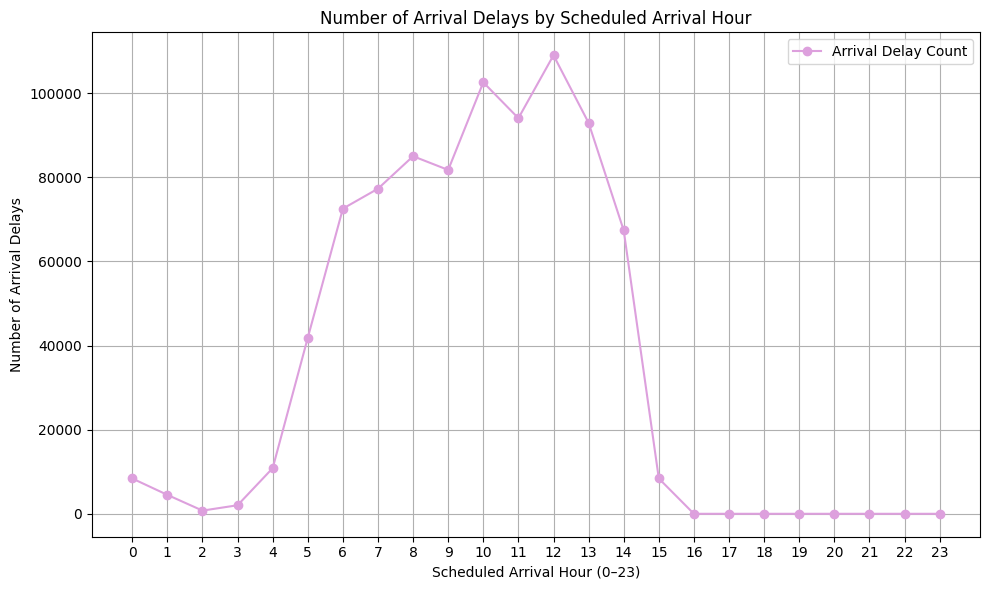

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert scheduled arrival time (CRSArrTime) to hours
df['ArrHour'] = (df['CRSArrTime'] // 100) + (df['CRSArrTime'] % 100) / 60.0
df['ArrHour'] = df['ArrHour'].round()  # Round to nearest hour

# Filter for delayed flights only
df_delayed = df[df['ArrDelay'] > 0].copy()

# Count delays per scheduled arrival hour (0–23)
delay_count_by_hour = df_delayed.groupby('ArrHour').size().reindex(range(24), fill_value=0)

# Plotting the delay counts by scheduled arrival hour
plt.figure(figsize=(10, 6))
plt.plot(delay_count_by_hour.index, delay_count_by_hour.values, marker='o', color='plum', label='Arrival Delay Count')
plt.title('Number of Arrival Delays by Scheduled Arrival Hour')
plt.xlabel('Scheduled Arrival Hour (0–23)')
plt.ylabel('Number of Arrival Delays')
plt.grid(True)
plt.legend()
plt.xticks(range(24))
plt.tight_layout()
plt.show()

The plot illustrates how the number of arrival delays varies across the sceduled arrival hours of the day, with a notable peak between 7 AM and 2 PM, where delays are most frequent, similar to the previous plot.

This could indicate that delays are more likely to accumulate during peak travel hours, potentially due to heavier air traffic or operational bottlenecks. 

Insights like this suggest that earlier hours, especially the morning, may be more vulnerable to disruptions, possibly due to overnight scheduling issues or the cumulative effect of delays from previous flights. 

Recognizing these trends can help identify key times for improvement in airport operations, staffing, or flight scheduling to minimize delays.

---------------------------------------------------------------------------------------------------------------------

## **Top 10 Airlines by % of Arrival Delayed Flights**

X-axis: Airline

Y-axis: Percent of Flights Delayed (Arrival Only)

The plot presents the top 10 airlines with the highest percentage of arrival delayed flights. The x-axis lists the airlines, and the y-axis represents the percentage of their flights that experienced arrival delays. This visualization helps to identify which airlines have the highest proportion of delayed flights, offering a clear comparison between them.

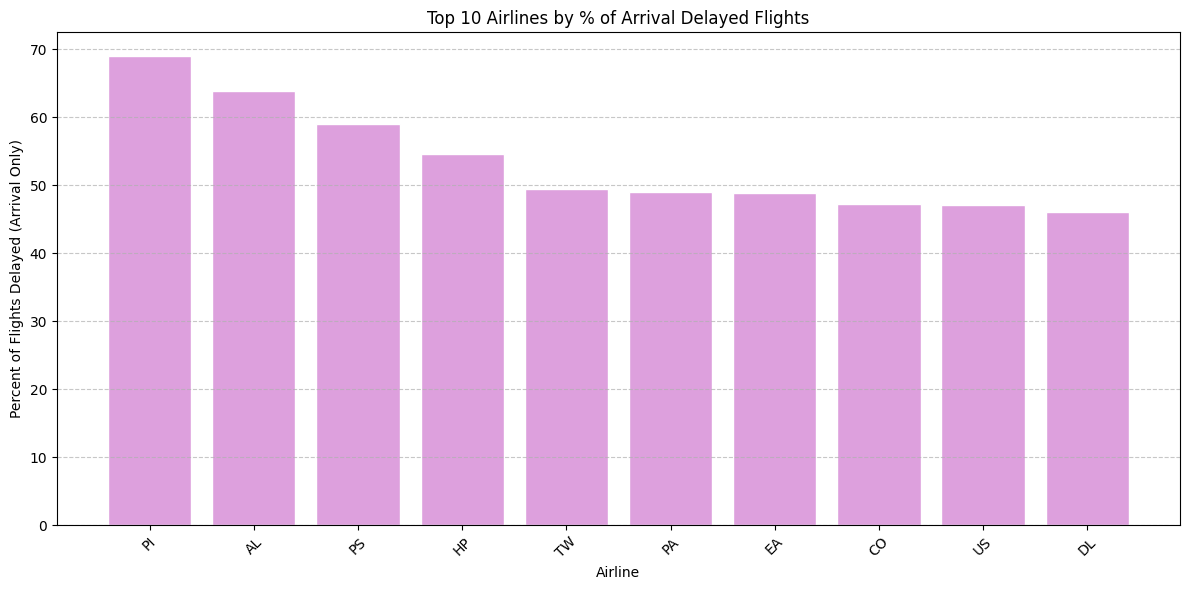

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Select the needed columns and make a copy to avoid SettingWithCopyWarning
data = df[['IATA_CODE_Reporting_Airline', 'ArrDelay', 'Flights']].copy()

# Step 2: Create the 'Delay' column using only arrival delay
data.loc[:, 'Delay'] = (data['ArrDelay'] > 0).astype(int)

# Step 3: Get total flights per airline
alldata = data[['IATA_CODE_Reporting_Airline', 'Flights']]
alldata = alldata.groupby('IATA_CODE_Reporting_Airline').sum().reset_index()
alldata.columns = ['Airline', 'Flights']

# Step 4: Get number of delayed flights per airline (arrival delays only)
delay_data = data[['IATA_CODE_Reporting_Airline', 'Delay']]
delay_data = delay_data.groupby('IATA_CODE_Reporting_Airline').sum().reset_index()
delay_data.columns = ['Airline', 'Delayed']

# Step 5: Merge total flights and delayed flights
ratio_data = pd.merge(alldata, delay_data, on='Airline', how='left')
ratio_data['Delayed'] = ratio_data['Delayed'].fillna(0)
ratio_data['Percent Delayed'] = (ratio_data['Delayed'] / ratio_data['Flights']) * 100

# Step 6: Sort by % delayed and take Top 10
ratio_data = ratio_data.sort_values('Percent Delayed', ascending=False).head(10)

# Step 7: Plot
plt.figure(figsize=(12, 6))
plt.bar(ratio_data['Airline'], ratio_data['Percent Delayed'], color='plum', edgecolor='white')
plt.title('Top 10 Airlines by % of Arrival Delayed Flights')
plt.xlabel('Airline')
plt.ylabel('Percent of Flights Delayed (Arrival Only)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The plot illustrates the top 10 airlines by the percentage of their flights that experience arrival delays. The airlines with the highest percentages of delays include PL, with approximately 70%, followed by AL and PS, which report delay rates between 55-60%. Airlines such as DL and US report delays around 45%.

The impact of these delays can be seen as certain airlines, such as PL, face more significant delays compared to others. 
This could be due to factors like higher flight volumes, air traffic congestion, or maintenance issues. 

Airlines with more delays may be dealing with challenges in scheduling, or they might face peak travel times that exacerbate the issue. 

Hence, we see that the airline itself can impact delays, and understanding these factors helps explain why some airlines experience more delays than others and what operational factors might be contributing to this.

---------------------------------------------------------------------------------------------------------------------

## **Number of Arrival Delays by Day of the Week**

X-axis: Day of the Week

Y-axis: Number of Arrival Delays

The plot displays the number of arrival delays for each day of the week. The x-axis shows the days of the week, from Sunday to Saturday, while the y-axis represents the total number of delays for each corresponding day. This line plot helps to visualize trends in delays across the days of the week, providing insights into which days might experience more frequent disruptions.

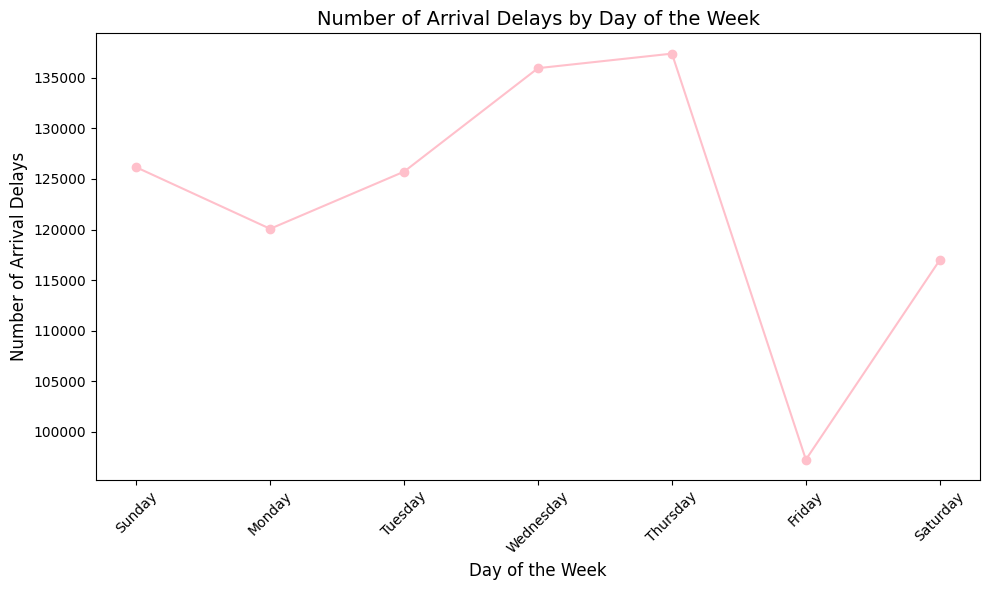

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create the 'Delay' column for arrival delays only
df['Delay'] = (df['ArrDelay'] > 0).astype(int)

# Step 2: Group by DayOfWeek and sum the delays (1 means delayed)
delay_by_day = df.groupby('DayOfWeek')['Delay'].sum().reset_index()

# Step 3: Map DayOfWeek values to their respective names
day_map = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
           5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
delay_by_day['Day'] = delay_by_day['DayOfWeek'].map(day_map)

# Step 4: Sort the data by DayOfWeek for proper chronological order
delay_by_day = delay_by_day.sort_values('DayOfWeek', ignore_index=True)

# Step 5: Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(delay_by_day['Day'], delay_by_day['Delay'], marker='o', linestyle='-', color='pink')

# Step 6: Add labels and title
plt.title('Number of Arrival Delays by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Arrival Delays', fontsize=12)
plt.xticks(rotation=45)

# Step 7: Display the plot
plt.tight_layout()
plt.show()

The plot illustrates the number of arrival delays across each day of the week. 

The highest number of delays is observed on Wednesday, Thursday, Saturday, and Sunday, suggesting that both the middle of the week and weekends are more prone to delays. 

This shows how the day of the week can impact delays, with operational factors like air traffic congestion, scheduling challenges, or maintenance issues potentially playing a role. 

---------------------------------------------------------------------------------------------------------------------

## **Top 10 Tail Numbers with Most Delays**

X-axis: Tail Number

Y-axis: Number of Delays

The plot shows the top 10 tail numbers with the most flight delays, highlighting the aircrafts most frequently experiencing delays. These tail numbers represent the planes that, for various operational reasons, are associated with the highest number of delays. Understanding which aircraft tend to have more delays can help airlines identify specific planes that may require more maintenance or better scheduling to improve overall operational efficiency.

Top tail numbers with the most delays:
Tail_Number
N963DL    214
N904DE    203
N972DL    202
N955DL    200
N956DL    199
N944DL    198
N913DE    196
N978DL    195
N951DL    195
N945DL    194
Name: count, dtype: int64


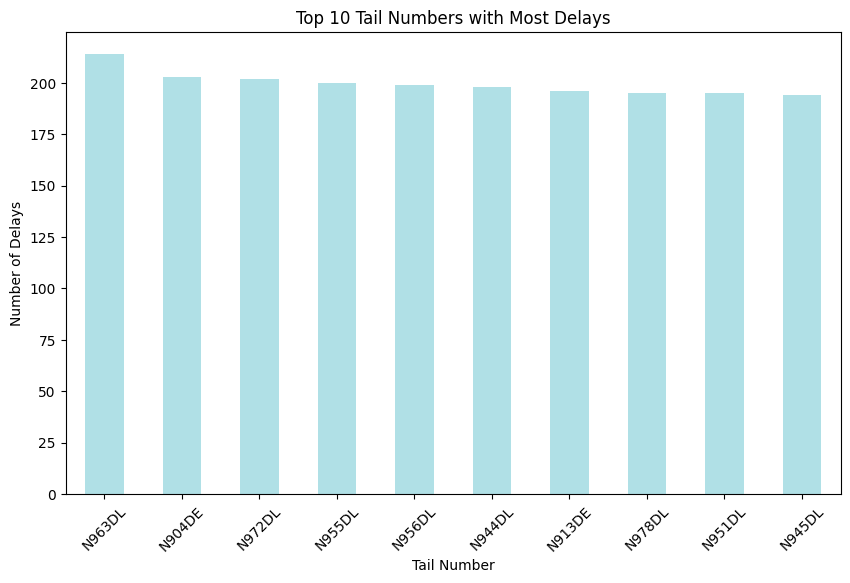

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Check for delayed flights by TailNumber
tail_number_delays = df[df['Delay'] == 1]['Tail_Number'].value_counts()

# Display the tail numbers with the most delays
print("Top tail numbers with the most delays:")
print(tail_number_delays.head(10))  # Top 10 tail numbers with the most delays

# Plot the delays per TailNumber
plt.figure(figsize=(10, 6))
tail_number_delays.head(10).plot(kind='bar', color='powderblue')
plt.title('Top 10 Tail Numbers with Most Delays')
plt.xlabel('Tail Number')
plt.ylabel('Number of Delays')
plt.xticks(rotation=45)
plt.show()

The top 10 tail numbers all have close to 200 delays, suggesting that there may not be a clear distinction in how each specific tail number impacts delays. 

---------------------------------------------------------------------------------------------------------------------

## **Inspecting Reused Flight Numbers and Their Details**

This section examines whether flight numbers are reused, identifies the flight numbers that appear more than once, and then provides a breakdown of the routes and dates associated with those reused flight numbers. Additionally, it inspects if any reused flights are potentially codeshared by analyzing the reporting airlines and aircraft tail numbers. 

This helps in understanding the frequency of flight number reuse and provides insight into any operational complexities such as codesharing that might affect flight scheduling or delays.


In [13]:
# Check if the flight numbers are reused
flight_counts = df['Flight_Number_Reporting_Airline'].value_counts()
print("Flight number counts:\n", flight_counts)

# Identify the flight numbers that are reused (appear more than once)
reused_flights = flight_counts[flight_counts > 1]
print("\nReused flight numbers:\n", reused_flights)

# Group by flight number and inspect the routes and dates
flight_group = df.groupby('Flight_Number_Reporting_Airline').agg({
    'Origin': 'first',  # Assuming 'Origin' column exists
    'Dest': 'first',    # Assuming 'Dest' column exists
    'FlightDate': lambda x: x.unique()  # Get all unique dates for the flight number
})

# Display the first few reused flight numbers and their details
print("\nFlight numbers with reused occurrences and their routes and dates:\n", flight_group.loc[reused_flights.index])

# Optional: You can also check if flights are codeshared by inspecting other columns like 'Reporting_Airline' or 'Tail_Number'
codeshare_flights = df.groupby('Flight_Number_Reporting_Airline').agg({
    'Reporting_Airline': lambda x: x.unique(),  # Unique reporting airlines for the same flight number
    'Tail_Number': lambda x: x.unique()  # Unique aircraft tail numbers
})
print("\nCodeshare flight details:\n", codeshare_flights)

Flight number counts:
 Flight_Number_Reporting_Airline
440     1347
500     1345
65      1333
505     1314
469     1307
        ... 
7559       1
7842       1
7907       1
7917       1
7645       1
Name: count, Length: 8050, dtype: int64

Reused flight numbers:
 Flight_Number_Reporting_Airline
440     1347
500     1345
65      1333
505     1314
469     1307
        ... 
7593       2
7574       2
7932       2
7840       2
7888       2
Name: count, Length: 8005, dtype: int64

Flight numbers with reused occurrences and their routes and dates:
                                 Origin Dest  \
Flight_Number_Reporting_Airline               
440                                SLC  IAH   
500                                STL  BWI   
65                                 JFK  MIA   
505                                RDU  STL   
469                                ORD  BNA   
...                                ...  ...   
7593                               AZO  ORD   
7574                          

The analysis reveals some flight numbers are reused, with a few flight numbers such as 440, 500, and 65 being reused across multiple dates. These reused flight numbers are associated with specific origins and destinations, showing that flights on these routes tend to operate repeatedly. 

Additionally, the analysis of codeshare flights indicates that some flight numbers are shared by multiple airlines, often with different tail numbers, suggesting collaborations between airlines. 

By identifying these reused flight numbers and understanding their associations, it becomes easier to assess whether these flights are prone to delays and how they may impact operational efficiency.

---------------------------------------------------------------------------------------------------------------------

## **Analyzing Flight Delays by Flight Number**

The analysis calculates the number of arrival delays. The data is grouped by flight number, and the sum of delays is computed for each flight. The result is sorted in descending order to highlight the flight numbers with the most delays. 

This can help identify specific flights that are frequently delayed.


In [14]:
# Create binary target variable 'DelayCategory': 1 if there was an arrival delay (ArrDelay > 0), 0 if there wasn't
df['DelayCategory'] = df.apply(lambda row: 1 if row['ArrDelay'] > 0 else 0, axis=1)

# Group by Flight Number and sum the DelayCategory to count delays
delays_by_flight = df.groupby('Flight_Number_Reporting_Airline')['DelayCategory'].sum().reset_index()

# Sort by the number of delays in descending order
delays_by_flight_sorted = delays_by_flight.sort_values(by='DelayCategory', ascending=False)

# Show the flight numbers with the most delays
print(delays_by_flight_sorted.head())  # You can adjust the number of rows to display as needed

     Flight_Number_Reporting_Airline  DelayCategory
504                              505            634
418                              419            621
439                              440            609
64                                65            605
507                              508            603


The analysis of the data shows the top flight numbers with the most arrival delays. 

Flight numbers like 505, 419, and 440 are among those that experience the highest number of delays, with counts reaching over 600 delays each. 

This suggests that these particular flights might be experiencing recurring issues that lead to frequent delays.

---------------------------------------------------------------------------------------------------------------------

## **Categorizing Distance and Checking the Frequency of Delays**

This section categorizes flights based on their distance into three categories: short (0-1000 miles), medium (1001-2000 miles), and long (2001-3000 miles). The next step involves analyzing the frequency of delays across these categories. A cross-tabulation is created to compare the number of delayed flights (ArrDelay > 0) against the total number of flights in each distance category.

By examining the ratio of delayed flights to total flights within each category, we can gain insights into how distance may influence the likelihood of delays, helping airlines to identify trends and patterns related to flight length and on-time performance.

In [11]:
# Categorizing distance (short/long) and checking the frequency of delays
df['DistanceCategory'] = pd.cut(df['Distance'], bins=[0, 1000, 2000, 3000], labels=['Short', 'Medium', 'Long'])

# Cross-tabulation of delay frequency by distance category
delay_by_distance = pd.crosstab(df['DistanceCategory'], df['ArrDelay'] > 0)  # True/False for delay
print(delay_by_distance)

print(f"---------------------------------")
# Calculate the ratio of delayed flights (True) to total flights for each distance category
delay_by_distance_ratio = delay_by_distance.div(delay_by_distance.sum(axis=1), axis=0)
print(delay_by_distance_ratio)

ArrDelay           False   True 
DistanceCategory                
Short             877828  657788
Medium            209819  162407
Long               51100   38180
---------------------------------
ArrDelay             False     True 
DistanceCategory                    
Short             0.571646  0.428354
Medium            0.563687  0.436313
Long              0.572357  0.427643


The analysis of flight delays by distance category reveals interesting insights into how the length of a flight may impact the likelihood of delays.

* For **short flights**, the data shows that 57.16% of the flights are on time (False), while 42.84% are delayed (True).
* For **medium flights**, approximately 56.37% are on time, and 43.63% experience delays.
* For **long flights**, 57.24% of the flights are on time, while 42.76% are delayed.

These figures suggest that there is no significant difference in the delay rate across distance categories, with each category showing a relatively similar distribution of on-time versus delayed flights.

However, distance in general still plays a role in influencing delays, as longer flights may encounter more variables and operational challenges.

---------------------------------------------------------------------------------------------------------------------

## **Title: Number of Arrival Delays by State (Origin)**

X-axis: Origin State

Y-axis: Number of Arrival Delays

This bar plot shows the number of arrival delays for flights originating from different states. The X-axis represents the states, while the Y-axis shows the count of delayed arrivals. The data indicates which states have the highest frequency of arrival delays, providing insights into potential operational challenges or trends in specific regions.

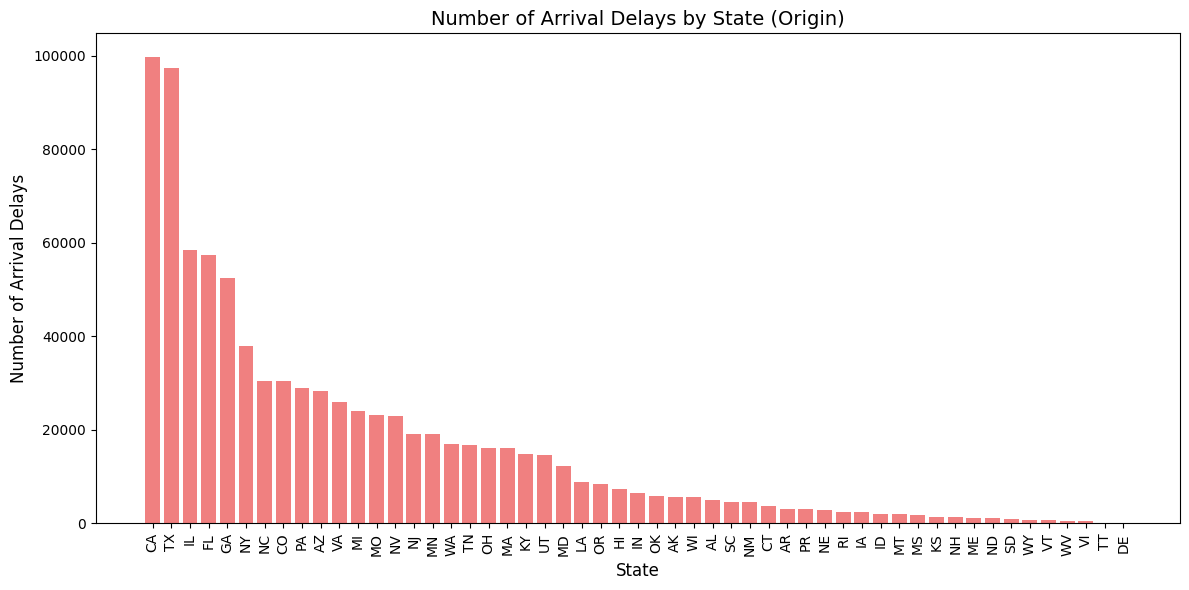

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create the 'Delay' column for arrival delays (1 means delayed)
df['Delay'] = (df['ArrDelay'] > 0).astype(int)

# Step 2: Group by OriginState and sum the delays (1 means delayed)
delay_by_state = df.groupby('OriginState')['Delay'].sum().reset_index()

# Step 3: Sort the states by Delay count in descending order
delay_by_state = delay_by_state.sort_values('Delay', ascending=False)

# Step 4: Create the bar plot for the top states with the highest delays
plt.figure(figsize=(12, 6))
plt.bar(delay_by_state['OriginState'], delay_by_state['Delay'], color='lightcoral')

# Step 5: Add labels and title
plt.title('Number of Arrival Delays by State (Origin)', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Arrival Delays', fontsize=12)
plt.xticks(rotation=90)

# Step 6: Display the plot
plt.tight_layout()
plt.show()

The analysis shows that certain states, particularly California (CA) and Texas (TX), have significantly higher numbers of arrival delays, with each state accounting for nearly 100,000 delays. 

On the other hand, states like Delaware (DE), Vermont (VT), and West Virginia (WV) report fewer than 2,000 delays. 

This stark contrast suggests that the origin state plays a notable role in the frequency of delays, with some states experiencing operational challenges or traffic volume that might contribute to more frequent delays.

---------------------------------------------------------------------------------------------------------------------

## **Title: Number of Arrival Delays by State (Destination)**

X-axis: Destination State

Y-axis: Number of Arrival Delays

This bar plot shows the number of arrival delays for flights arriving in different states. The X-axis represents the destination states, while the Y-axis shows the count of delayed arrivals. The data reveals which destination states have the highest frequency of arrival delays, providing insights into potential operational challenges or trends in those regions.

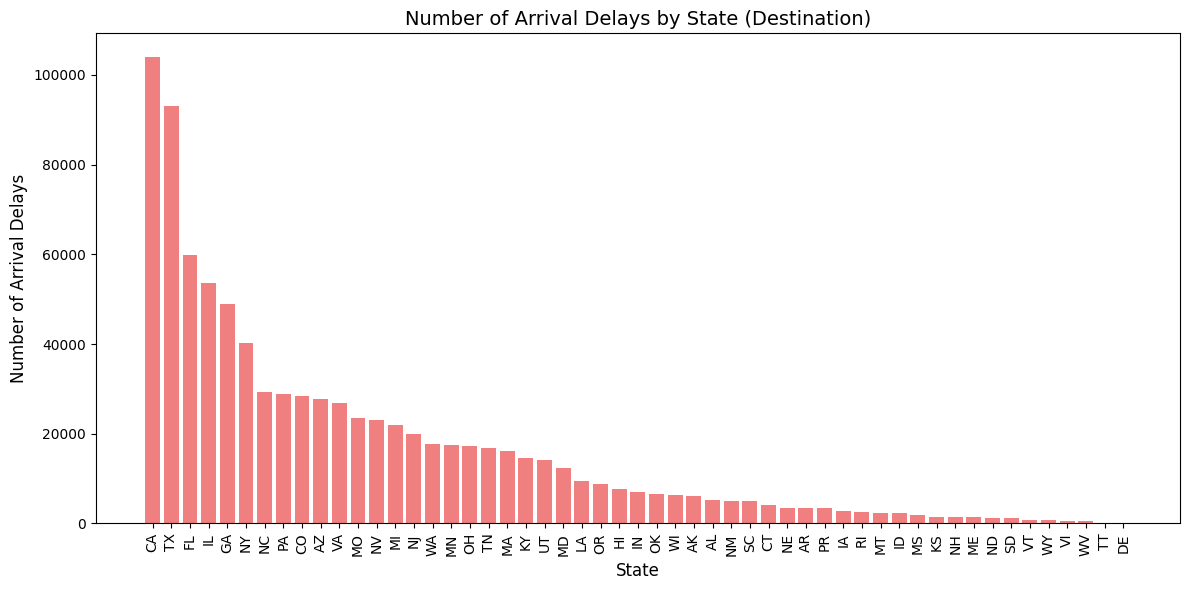

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create the 'Delay' column for arrival delays (1 means delayed)
df['Delay'] = (df['ArrDelay'] > 0).astype(int)

# Step 2: Group by OriginState and sum the delays (1 means delayed)
delay_by_state = df.groupby('DestState')['Delay'].sum().reset_index()

# Step 3: Sort the states by Delay count in descending order
delay_by_state = delay_by_state.sort_values('Delay', ascending=False)

# Step 4: Create the bar plot for the top states with the highest delays
plt.figure(figsize=(12, 6))
plt.bar(delay_by_state['DestState'], delay_by_state['Delay'], color='lightcoral')

# Step 5: Add labels and title
plt.title('Number of Arrival Delays by State (Destination)', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Arrival Delays', fontsize=12)
plt.xticks(rotation=90)

# Step 6: Display the plot
plt.tight_layout()
plt.show()

The analysis shows that certain destination states, particularly California which leads with over 100,000 delays, followed by Texas with around 90,000 delays.

On the other hand, states like Delaware (DE), Vermont (VT), and West Virginia (WV) report fewer than 2,000 delays.

This stark contrast suggests that the destination state plays a notable role in the frequency of delays, with some states experiencing operational challenges, higher traffic volume, or other factors contributing to more frequent delays.

---------------------------------------------------------------------------------------------------------------------

## **Summary: Features That Impact Flight Delay**

The analysis of various features reveals several key factors that significantly impact flight delays. These features, derived from visual insights and feature engineering techniques, provide a comprehensive understanding of the conditions contributing to delays:

- Time-Related Features:

Scheduled Arrival Time (CRSArrTime): The time of day when flights are scheduled to arrive influences delay patterns. Flights scheduled to arrive during peak periods (6 AM to 2 PM) tend to experience more delays.

High-Delay Seasons: Flights in certain months (e.g., January, March, June, July, and December) show a higher frequency of delays, possibly due to seasonal factors like weather conditions or increased travel volume.

Weekday/Weekend: Weekends (Saturday and Sunday) are more likely to have delayed flights, with specific weekdays like Wednesday and Thursday also showing higher delay rates.

- Airline and State-Based Features:

High-Delay Airlines: Certain airlines, such as PI, AL, and AA, experience more frequent delays, potentially due to operational factors.

Origin and Destination States: States like California (CA), Texas (TX), and Florida (FL) both as origin and destination points see a significant number of delays. States with higher traffic volumes or operational challenges contribute to more frequent delays.

- Aggregated Delay Rates:

Airline, Origin, and Destination Delay Rates: Historical delay rates for airlines, origin states, and destination states play an important role in predicting delays. Airlines and routes with historically high delay rates are more likely to encounter delays.

Route-Specific Delays: Certain routes with higher weather-related delays or NAS delays also impact overall delays on those routes.

- Flight-Specific Features:

Highest Delayed Flight Numbers: Specific flight numbers that consistently experience delays can be flagged for further investigation. These high-delay flights indicate operational bottlenecks or frequent issues that may require special attention.

---------------------------------------------------------------------------------------------------------------------

In conclusion, time of day, seasonal trends, airline performance, and specific routes all contribute to the likelihood of delays. The combination of these factors helps create a comprehensive picture of the operational environment surrounding flight delays, making it easier to predict and manage delays more effectively.